In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt

# Cleaning data
Some data doesn't have address and some of them have unreasonably high Areas in order of like bilions.<br>
For the first problem i removed all of data with nan in Address.<br>
For other one first i should have converted all of Areas from string to int and i did it with first converting Area column to list, removing white spaces from left and right and ',' seprations. now a logical expration can handle the rest.

In [2]:
df = pd.read_csv("housePrice.csv")
df = df.drop(df[df.Address.isna()].index)
temp = df.Area.tolist()
temp = [int(s.strip().replace(',', '')) for s in temp]
df.Area = temp
df = df.drop(df[df.Area > 1000].index)

adf = df[df.Area > 200]
adf.head(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
59,215,3,True,True,True,Pakdasht,1.750000e+09,58333.33
84,300,3,True,True,False,Baghestan,1.500000e+09,50000.00
160,245,3,True,True,True,Farmanieh,2.695000e+10,898333.33
174,236,4,True,True,True,Gheitarieh,2.000000e+10,666666.67
177,220,3,True,True,True,Heravi,1.540000e+10,513333.33
190,320,4,True,True,True,Saadat Abad,2.400000e+10,800000.00
196,210,3,True,True,True,Pasdaran,1.575000e+10,525000.00
201,270,4,True,True,True,Farmanieh,3.780000e+10,1260000.00
227,210,3,True,True,True,Shahrake Gharb,2.700000e+10,900000.00
265,230,3,True,True,True,Niavaran,2.530000e+10,843333.33


# Looking at whole trend
Defenetly Price is a function of area.<br>
For Proving theory i scatterplot Price in front of Area.<br>
Consdiering high density of data in area lower than 200 meters area setting alpha to 0.1 can show how data main stream behaves.

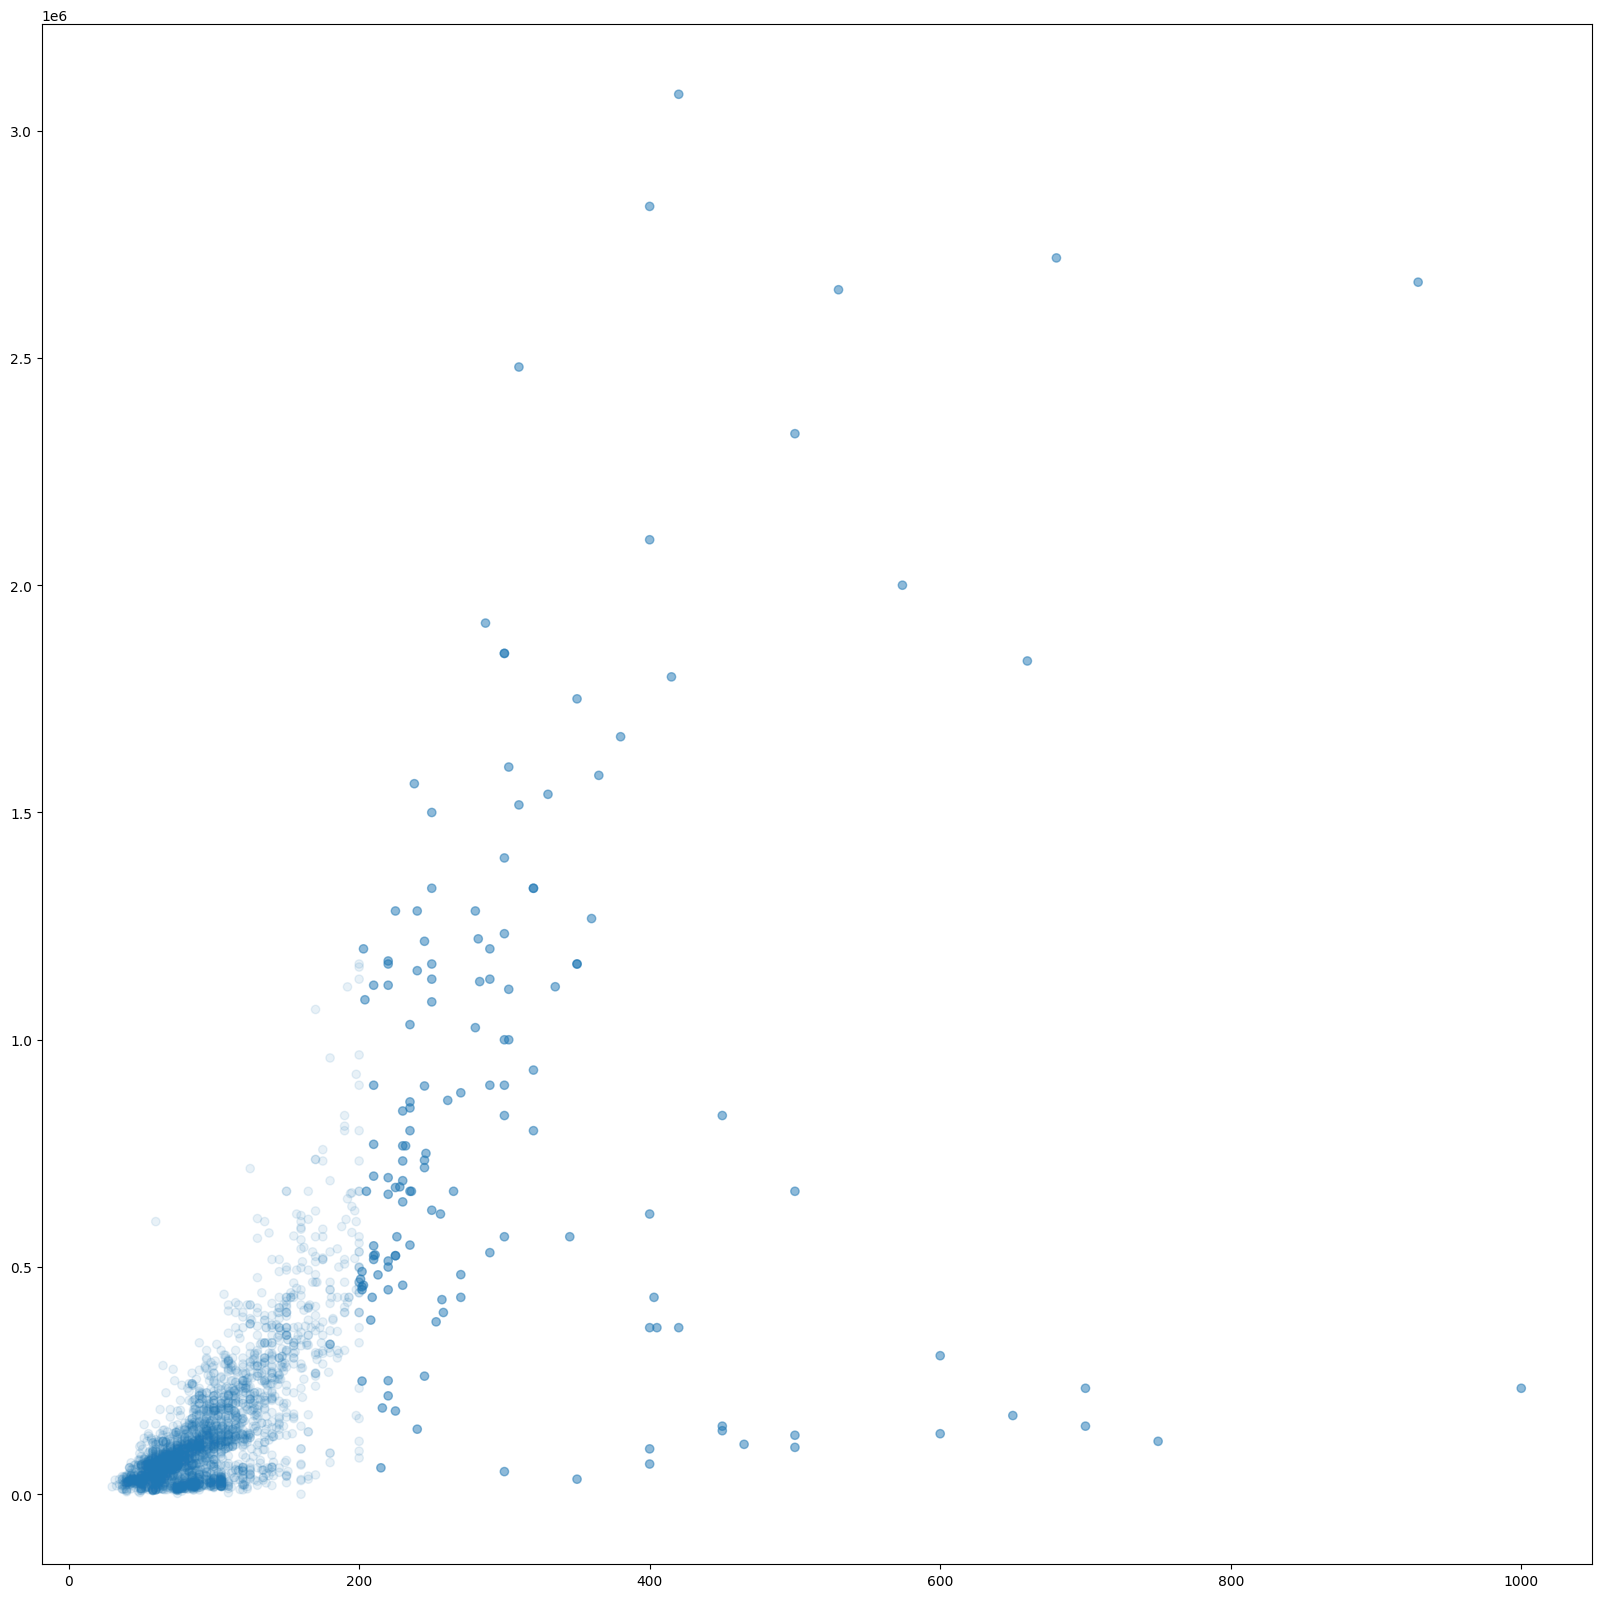

In [8]:
msk = np.random.rand(len(df)) < 0.8
cdf = df[msk]

plt.figure(figsize = (20, 20))
a = (cdf.Area <= 200)
a = [0.1 if i else 0.5 for i in a]
plt.scatter(cdf.Area, cdf['Price(USD)'], alpha = a)

## Price to Area in same Address
Last part showed that Price is a function of Area but the relationship is not clear.<br>
My first guess is that in each Address there is a linear or even exponential relationship between them.So in order to test them first i need to 
map each address to number of data that it contains then scatter plot most populated ones to see what happens.<br>
Points on Address has been shown in orange color in front of all data points to see have diffrent neighborhoods have diffrent slopes.

In [12]:
count_dict = df['Address'].value_counts()
print(count_dict)

<class 'pandas.core.series.Series'>


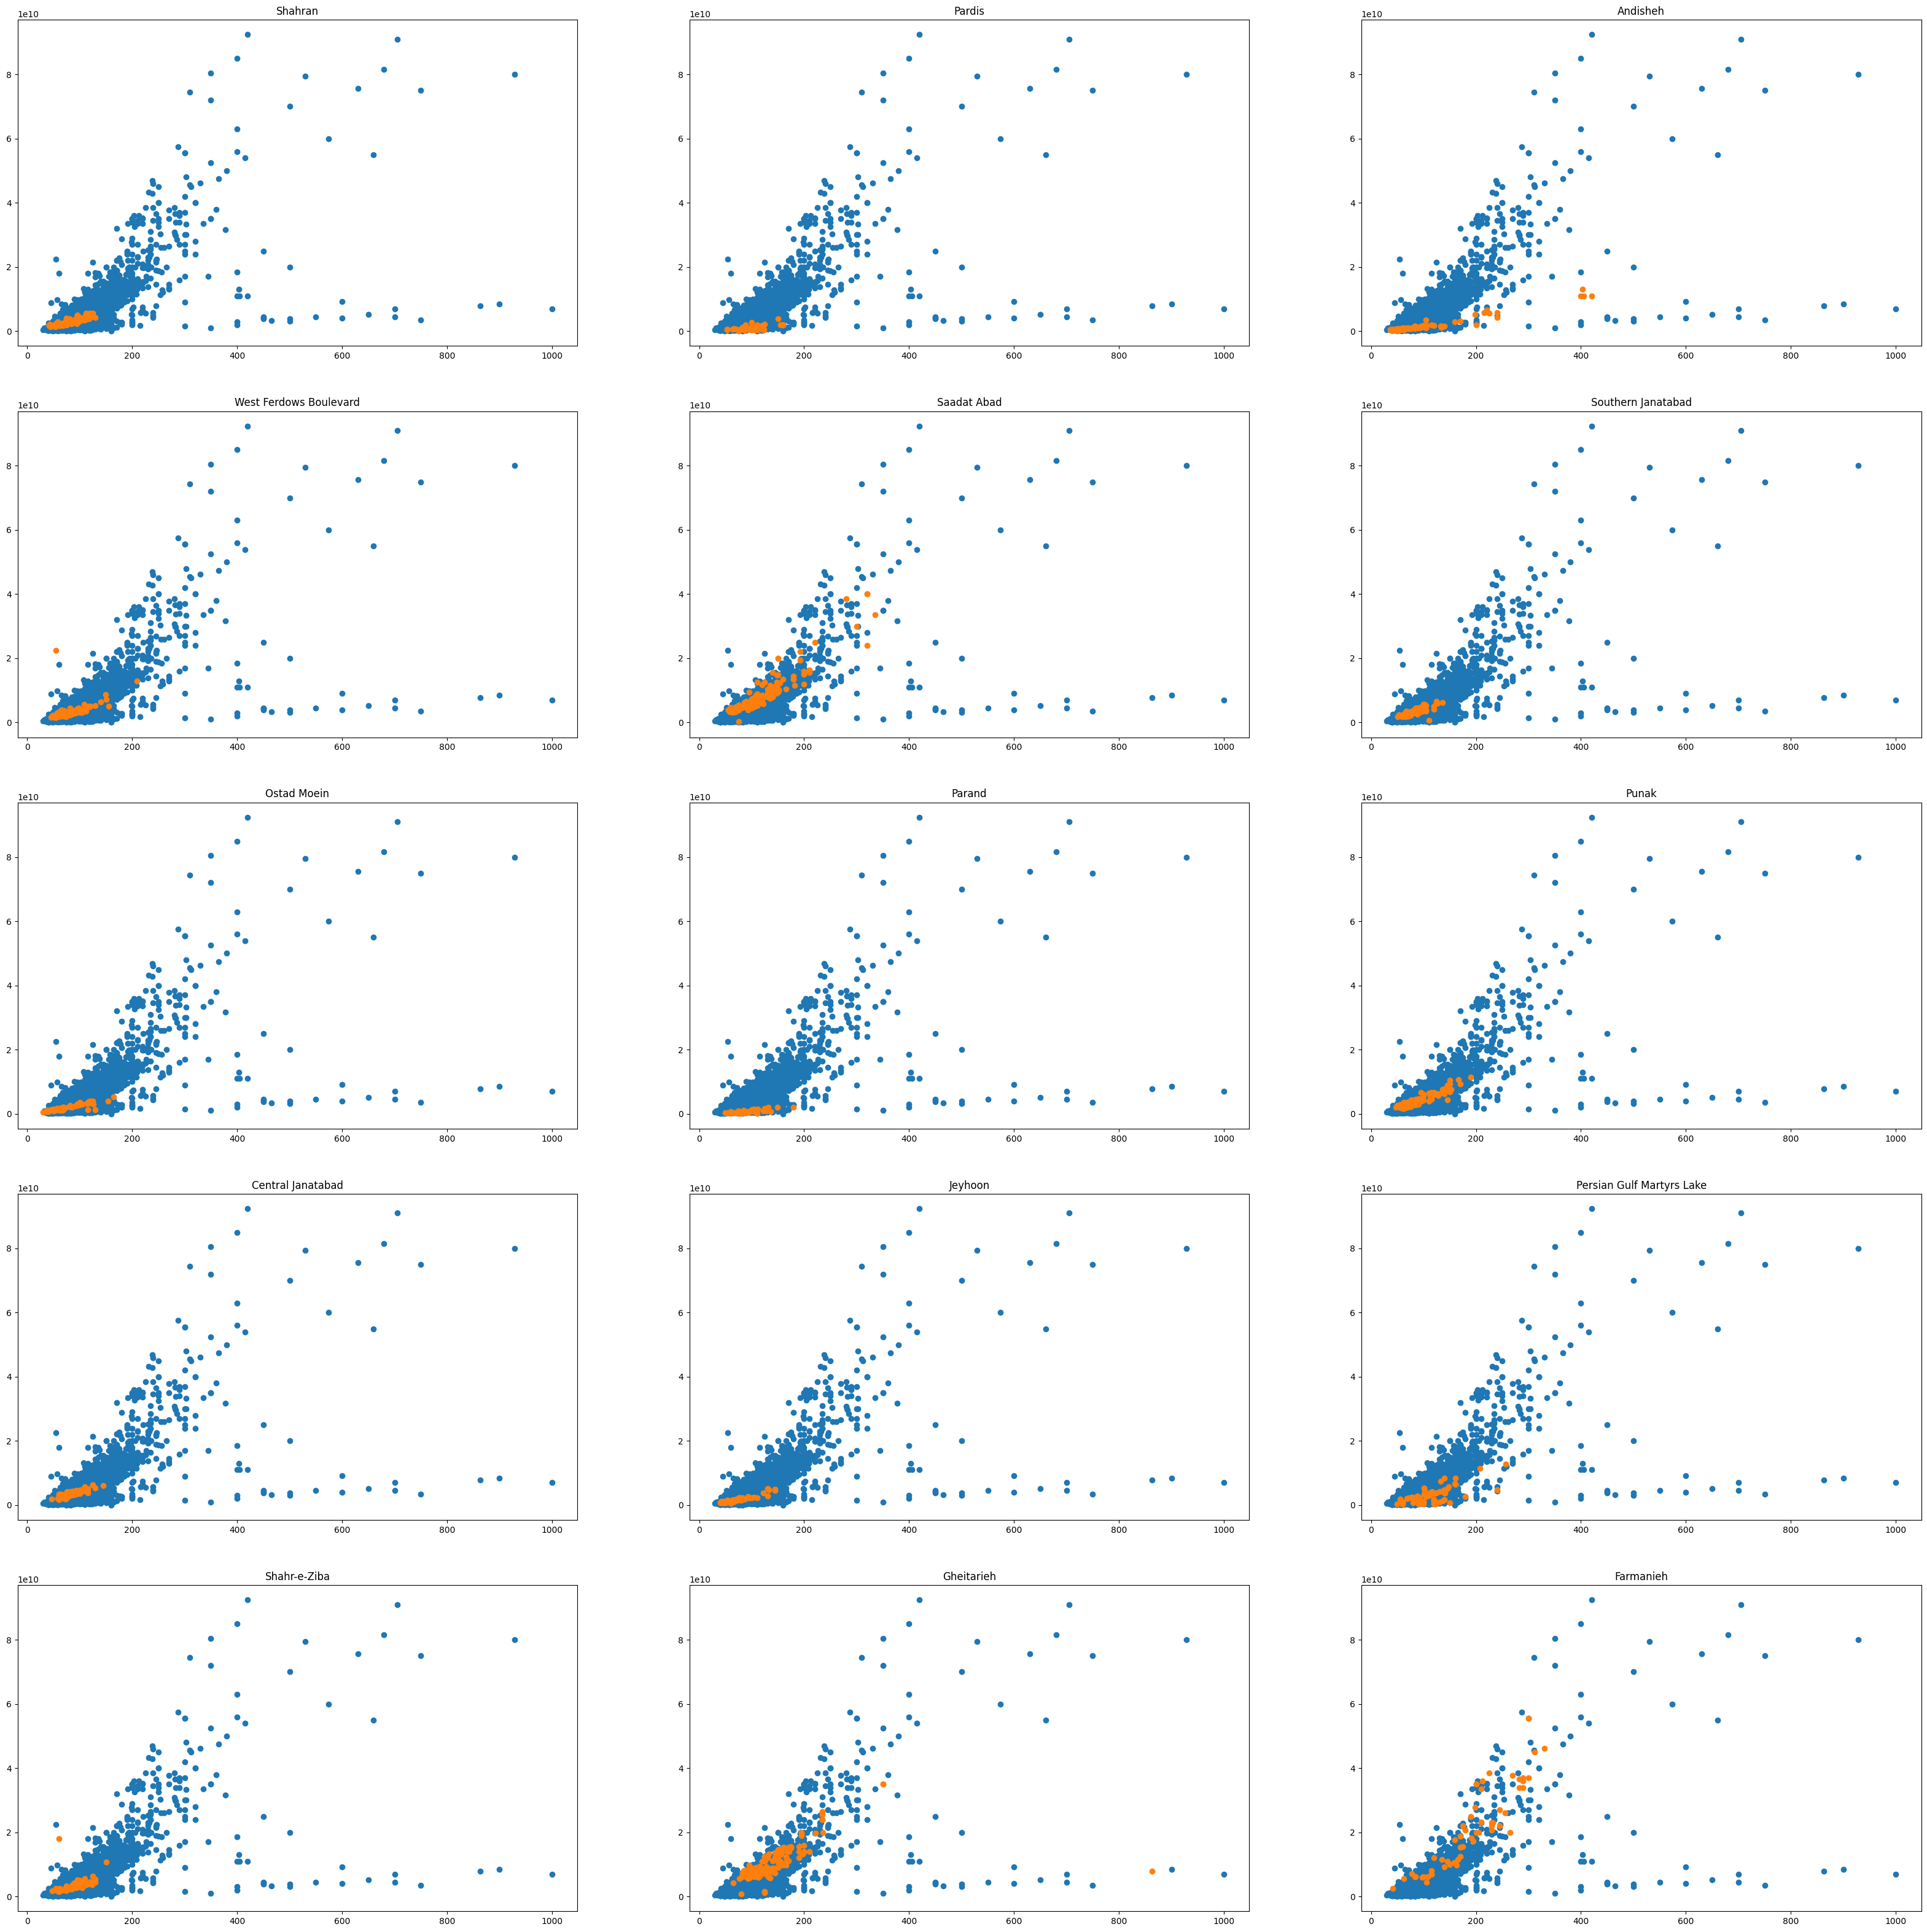

In [10]:
figs = [k for k, v in count_dict.items() if v>80]
plt.figure(figsize = (40, 40))
figs.append('Farmanieh')

for fig in figs:
    plt.subplot(5, 3,figs.index(fig)+1)
    logic = (df.Address == fig)
    
    cdf = df[logic]
    cdf2 = df[~logic]

    plt.scatter(cdf2.Area, cdf2.Price)
    plt.scatter(cdf.Area, cdf.Price)
    plt.title(fig)

## Deriving clustering variables
From plots above it is clear that there is reasonable linear patterns but variance of slopes and intercepts are high.<br>
We cannot develpe an regression model for each address becuse there is just not enough data for each and for some of that number is 2 or 1!<br>
Another approch to solving this problem is to try make some generic clusters of Addresses and cluster them and then train a model for each.<br>
In order to do that first i should make an variable for clustering. Better neighbors should have higher rate of changes higher mean price and mean Area
and even more maximum to minimum price diffrence. Each one of these are drived and plotted to see any relationship.<br>
From expriences it is been shown that neighbors with less than 5 datas creates unrealstic slope and intercepts so i clear them before Proccessing.

Text(0, 0.5, 'maxMin y')

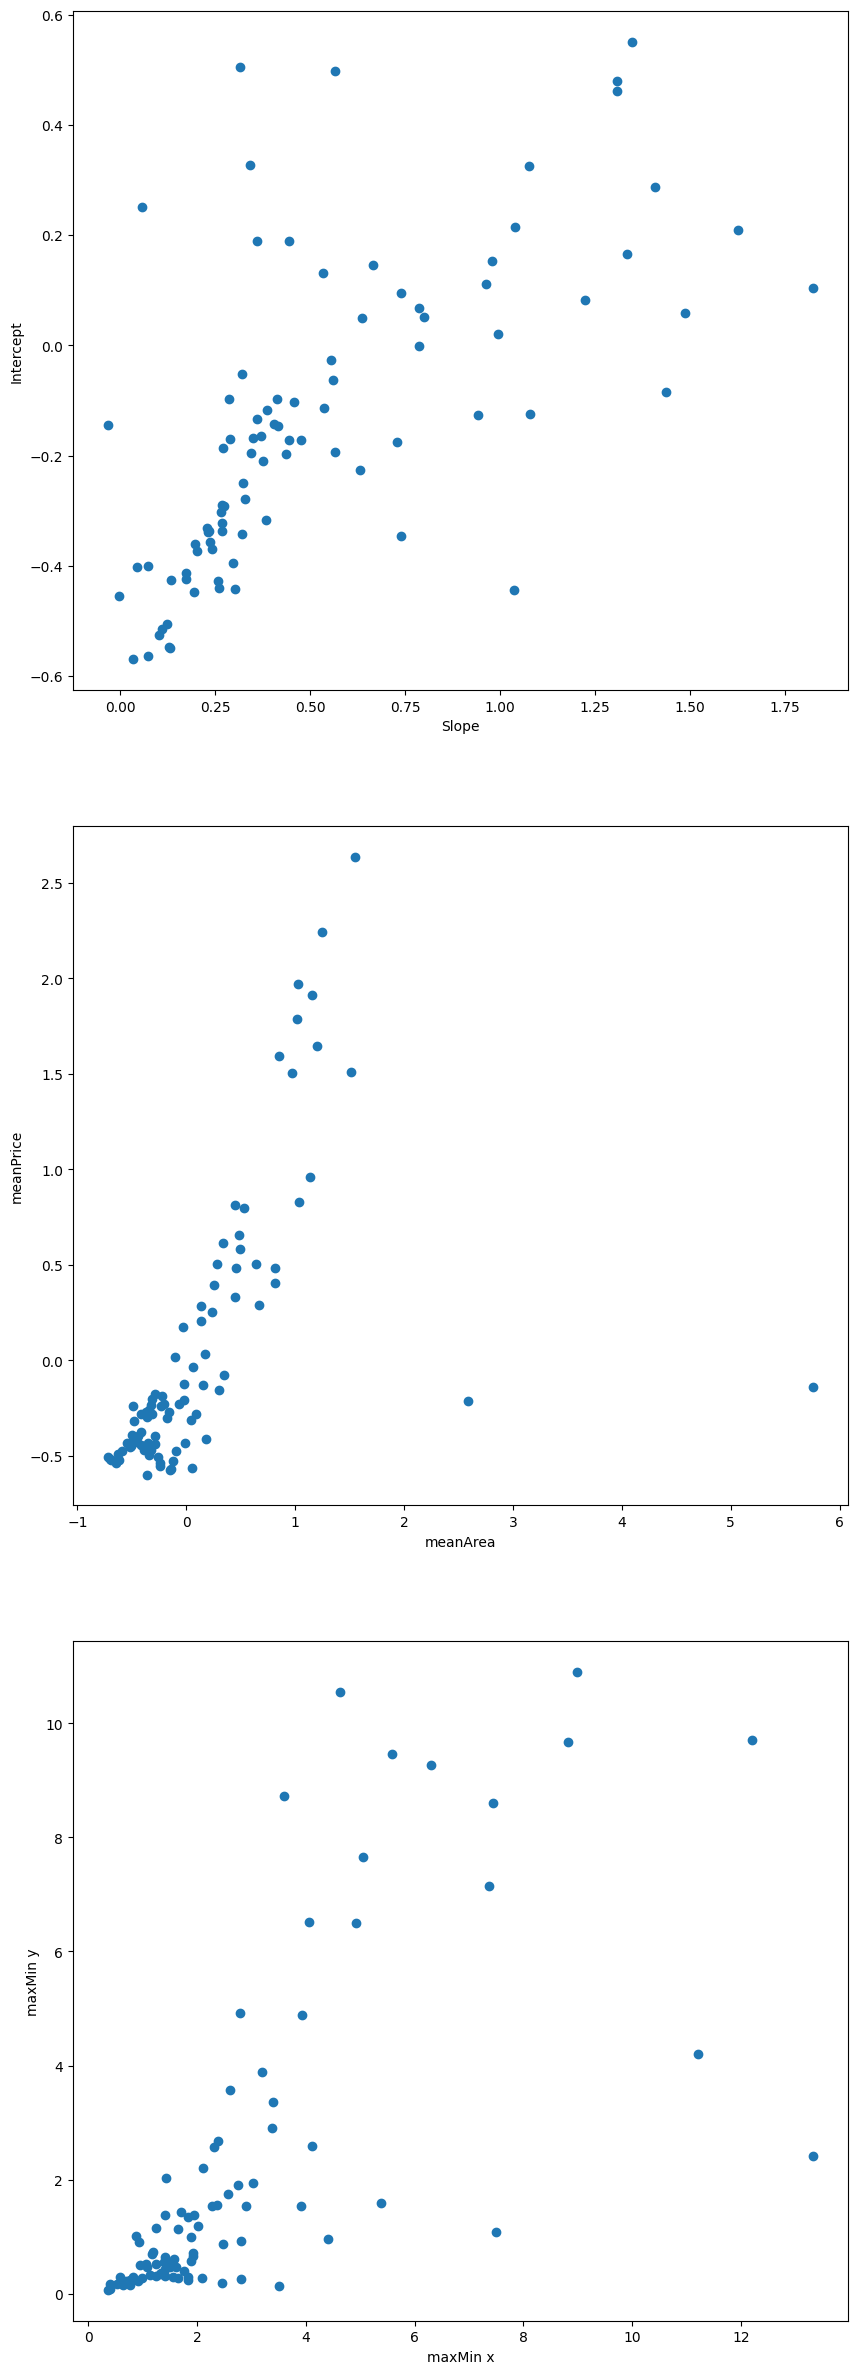

In [13]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


# filtering addresses with more than 5 data and other in saprate lists
figs = [k for k, v in count_dict.items() if v>5]
remFigs = [k for k in count_dict.keys() if k not in figs]



# Potential Clustering independent variables
size = len(figs)
slope = np.zeros(size)
intercept = np.zeros(size)
mean = np.zeros((size, 2))
maxMin = np.zeros((size, 2))
name = []
i = 0


# Standardizing data in order to have less varient slope intercept and ...
scalerX = StandardScaler().fit(np.asarray(df.Area).reshape(-1, 1))
scalerY = StandardScaler().fit(np.asarray(df.Price).reshape(-1, 1))

for address in figs:
    cdf = df[df.Address == address]

    x = np.asarray(cdf.Area).reshape(-1, 1)
    y = np.asarray(cdf.Price).reshape(-1, 1)
    x = scalerX.transform(x)
    y = scalerY.transform(y)

    mean[i][0] = np.mean(x)
    mean[i][1] = np.mean(y)

    maxMin[i][0] = np.max(x) - np.min(x)
    maxMin[i][1] = np.max(y) - np.min(y)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    
    slope[i] = regr.coef_[0][0]
    intercept[i] = regr.intercept_[0]
    name.append(address)

    i += 1
    
        
plt.figure(figsize=(10, 30))

# Ploting slope and intercepts in 2d Plane
plt.subplot(3, 1, 1)
plt.scatter(slope, intercept)
plt.xlabel('Slope')
plt.ylabel('Intercept')


plt.subplot(3, 1, 2)
plt.scatter(mean[:,0], mean[:, 1])
plt.xlabel('meanArea')
plt.ylabel('meanPrice')


plt.subplot(3, 1, 3)
plt.scatter(maxMin[:,0], maxMin[:, 1])
plt.xlabel('maxMin x')
plt.ylabel('maxMin y')

# KMeans Clustering
Best algorithm for my porpuse indeed. To find optimal values i try diffrent k values and even diffren x variables. beside ones that has been commented 
i try just slope clustering to and this the best out of all variations.

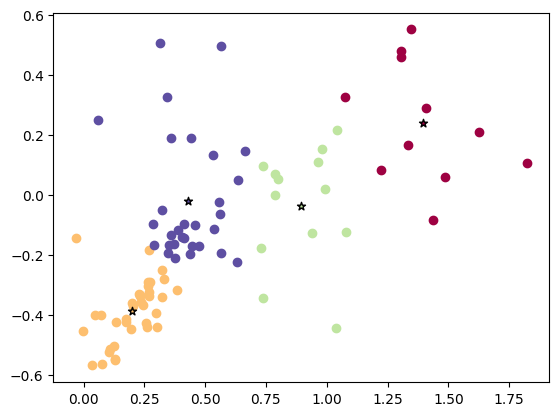

In [17]:
from sklearn.cluster import KMeans

k = 4    #number of clusters
trends = []   #all lists with cluster names will be saved in
name = np.asarray(name)


# Trying diffrent xs as independent variable of clustring
x = list(zip(slope, intercept))
x = np.asarray(x)
    # x = mean
    # x = maxMin


# Making sample of algorithm and fitting it to x
k_means = KMeans(n_clusters=k, n_init = 30)
k_means.fit(x)

# Kmeans centers of each cluster will be saved in centers
centers = k_means.cluster_centers_

# Spectral creates k colors in specified range to color clusters diffrently
colors = plt.cm.Spectral(np.linspace(0, 1, k))


for l, col in zip(range(k), colors):
    # Filtering points and centerPoints that are in same cluster
    my_members = (k_means.labels_ == l)   
    cen = centers[l]

    # Addresses with same cluster will go on a list on Trends
    trends.append(list(name[my_members]))

    # Scatter ploting each cluster with diffrent colors
    plt.scatter(x[my_members, 0], x[my_members, 1], color = col)
    # Centers will be shown with stars that have black margins
    plt.scatter(cen[0], cen[1], marker = '*', color = col, edgecolor = 'k')


# For addresess that wasn't been in x we pass them in one cluster by making predictions
for address in remFigs:
    cdf = df[df.Address == address]

    x = np.asarray(cdf.Area).reshape(-1, 1)
    y = np.asarray(cdf.Price).reshape(-1, 1)
    x = scalerX.transform(x)
    y = scalerY.transform(y)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    x = regr.coef_[0]
    y = regr.intercept_

    ind = list(zip(x,y))
    ind = np.asarray(ind)
    trnd = k_means.predict(ind)[0]
    trends[trnd].append(address)

# Fitting Regression Lines
I have been used cross validation in order to decide which model has better performance and mean of all trends as whole model juding factor.

degree: 1 mean score: 0.8240473487545197 scores: [0.88269531 0.78352615 0.91509699 0.79457418 0.74434412]
degree: 2 mean score: 0.2702959059854547 scores: [0.3141551  0.30416653 0.11931828 0.21273212 0.40110751]
degree: 1 mean score: 0.8349550966250675 scores: [0.57917187 0.90593296 0.76900728 0.95301218 0.96765118]
degree: 2 mean score: 0.6802520593659576 scores: [0.67492414 0.73225738 0.73325126 0.69137518 0.56945234]
score: 0.6523876026827498


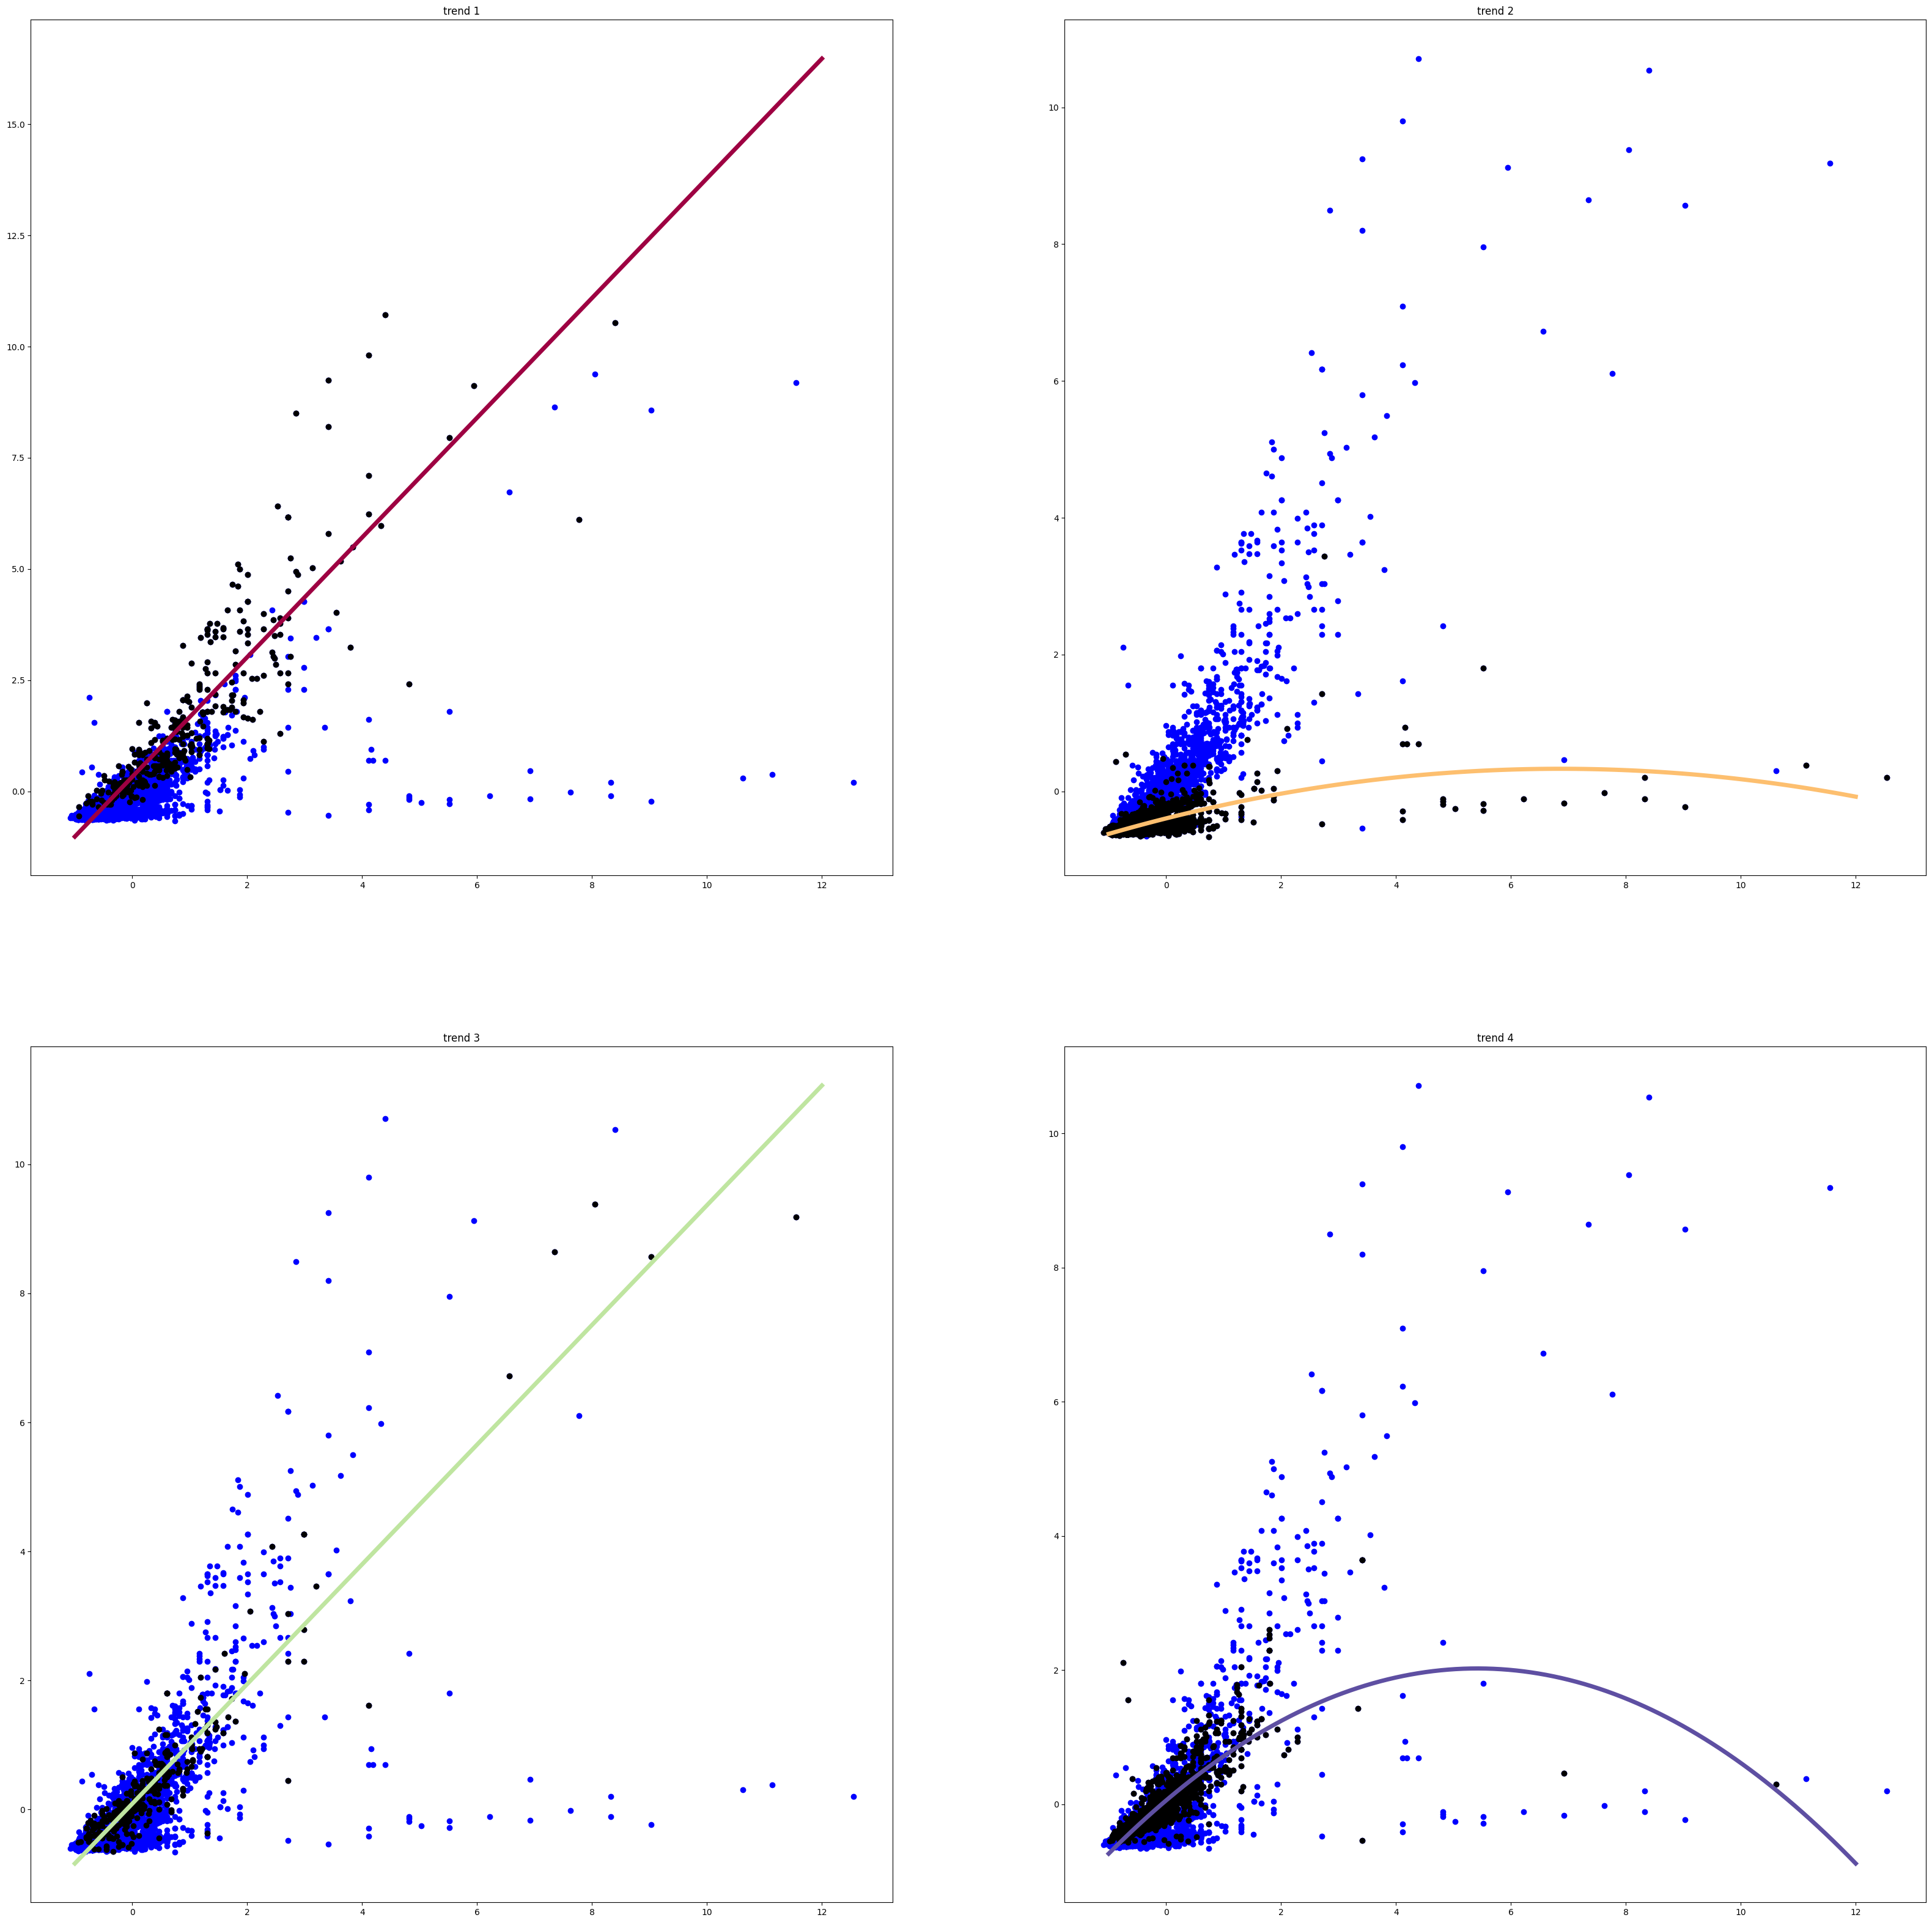

In [21]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from math import ceil


regrs = []    #saving regression models to plot them afterwards
degrees = []    #optimal value of polynominal degree for each plot
scores = []     #r2_score derived from cross validation + mean value of all for optimal model
maxDegree = 3    #curves with terms that have more than 3 degrees will result overfitting
sumMean = 0     #sum of all mean score values

plt.figure(figsize = (40, 40))

# Standardization
x = scalerX.transform(np.asarray(df.Area).reshape(-1, 1))
y = scalerY.transform(np.asarray(df.Price).reshape(-1, 1))

    
for trnd in trends:
    j = 1    #itrate throw degrees
    i = trends.index(trnd)     #itrate throw trends
    
        
    while j<maxDegree:
        # Creating model
        regr = linear_model.LinearRegression()
        poly = PolynomialFeatures(degree=j, include_bias=False)
            
        # DataFrame that contains only a trend data       
        dt = df[df.Address.isin(trnd)]

        # X and Y variables
        X = np.asarray(dt.Area).reshape(-1, 1)
        X = scalerX.transform(X)
        polyX = poly.fit_transform(X.reshape(-1, 1))    
        Y = np.asarray(dt.Price).reshape(-1, 1)
        Y = scalerY.transform(Y)
                
            
        regr.fit(polyX, Y)
        
        # CV will shufle data with same random for each model and split it into 5 bags
        cv = ShuffleSplit(n_splits=5, random_state=10)

        # Cross validating model and saving score values
        score = cross_val_score(regr, polyX, Y, scoring='r2', cv=cv)
        score = np.append(score, np.mean(score))

        
        # Finding optimal score value and regression model and saving them
        if len(scores) <= i:
            scores.append(score)
            degrees.append(j)
            regrs.append(regr)
        elif score[5] > scores[i][5]:
            scores[i] = score
            degrees[i] = j
            regrs[i] = regr
    
        j += 1


    # Showing results  
    print(f'degree: {degrees[i]} mean score: {scores[i][5]} scores: {scores[i][0:5]}')
    sumMean += scores[i][5]
    
    plt.subplot(2, ceil(k/2), i+1)
    plt.title(f"trend {i+1}")

    # Ploting whole and trend points in diffrent colors
    msk = (df.Address.isin(trnd))
    plt.scatter(x, y, color = 'blue')
    plt.scatter(x[msk], y[msk], color = 'k')

    # Drawing curves with colors of last figure
    X = np.linspace(-1, 12, 100).reshape(-1, 1)
    poly = PolynomialFeatures(degree=degrees[i], include_bias=False)
    polyX = poly.fit_transform(X.reshape(-1, 1))
    plt.plot(X, regrs[i].predict(polyX), color = colors[i], linewidth = 5)

print(f"score: {sumMean/k}")